In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import VGG16, Xception, InceptionV3, MobileNet, ResNet50
from tensorflow.keras.preprocessing import image

In [2]:
def plot_predictions_for_class(data, class_id, figsize=(10,7)):
    """
    Plots the distribution of the predictions given a label
    """
    subset = data[data["Labels"] == class_id]
    plt.figure(figsize=figsize)
    plt.title("Count per Predicted Label")
    plt.xlabel("Food Item")
    plt.ylabel("Count")
    value_counts = subset["Predictions"].value_counts().plot(kind="bar")
    return value_counts

def get_most_accurate(data, k=1):
    """
    Returns top k most accurate predictions
    """
    subset = data[data["Labels"]==data["Predictions"]]
    results = (subset["Labels"].value_counts()/data["Labels"].value_counts()).sort_values(ascending=False)[:k]
    return results

In [19]:
batch_size = 32
shape = (224, 224)

# data augmentation
datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=True, # randomly flip images
    width_shift_range=0.1, # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2, # randomly shift images vertically (fraction of total height)
    rotation_range=10, # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range=0.05, # randomly zoom image
    brightness_range=[0.4, 0.8],
    fill_mode="reflect"
    ) 

train_generator = datagen.flow_from_directory(
    directory="subset_images/train",
    target_size=shape,
    color_mode="rgb",
    shuffle=True,
    batch_size=batch_size,
    class_mode="categorical",
    seed=2019)

valid_generator = datagen.flow_from_directory(
    directory="subset_images/valid",
    target_size=shape,
    color_mode="rgb",
    shuffle=True,
    batch_size=batch_size,
    class_mode="categorical",
    seed=2019)

test_generator = datagen.flow_from_directory(
    directory="subset_images/test",
    target_size=shape,
    color_mode="rgb",
    shuffle=False,
    batch_size=1,
    class_mode="categorical")

num_classes = len(train_generator.class_indices)

# create step size
STEP_SIZE_TRAIN=np.ceil(train_generator.n/train_generator.batch_size)
STEP_SIZE_VALID=np.ceil(valid_generator.n/valid_generator.batch_size)
STEP_SIZE_TEST=np.ceil(test_generator.n/test_generator.batch_size)

print(STEP_SIZE_TRAIN)
print(STEP_SIZE_VALID)
print(STEP_SIZE_TEST)

Found 4076 images belonging to 101 classes.
Found 1078 images belonging to 101 classes.
Found 1299 images belonging to 101 classes.
128.0
34.0
1299.0


In [20]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(shape[0], shape[1], 3), padding='same', use_bias=False, kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), input_shape=(shape[0], shape[1], 3), padding='same', use_bias=False, kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64, (3, 3), padding='same', use_bias=False, kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), padding='same', use_bias=False, kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))

model.add(Conv2D(128, (3, 3), padding='same', use_bias=False, kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation="softmax"))

In [21]:
# compile
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=0.0001, decay=1e-6),
              metrics=['acc'])

In [22]:
# callbacks
earlyStopping = EarlyStopping(monitor="val_loss", patience=10, verbose=0, mode="min")
checkpoint = ModelCheckpoint(os.path.join("models", "model-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5"), verbose=1, 
                             monitor="val_loss", save_best_only=True, mode="auto")
reduce_lr_loss = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode="min")

In [23]:
import missinglink
missinglink_callback = missinglink.KerasCallback()

In [12]:
# fit base model
model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    callbacks=[missinglink_callback,earlyStopping, checkpoint, reduce_lr_loss],
                    epochs=100, verbose=2)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 128.0 steps, validate for 34.0 steps


/Users/dineshp/.pyenv/versions/3.7.6/lib/python3.7/site-packages/missinglink_kernel/callback/dispatchers/json_encoder.py:24: UserWarning: skipped MissingLinkJsonEncoder because of TypeError Object of type ResourceVariable is not JSON serializable
  warnings.warn(msg)


Epoch 1/100


ExperimentStopped: Experiment was stopped.

In [ ]:
# fit base model
#model.fit_generator(generator=train_generator,
#                    steps_per_epoch=STEP_SIZE_TRAIN,
#                    validation_data=valid_generator,
#                    validation_steps=STEP_SIZE_VALID,
#                    callbacks=[earlyStopping, checkpoint, reduce_lr_loss],
#                    epochs=1, verbose=2)

## Transfer Learning => VGG 

In [24]:
# load base MobileNet
base_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(shape[0], shape[1], 3))

In [25]:
top_block = base_vgg16.output

top_block = GlobalAveragePooling2D()(top_block) # pool over height/width to reduce number of parameters
top_block = Dense(256, activation='relu')(top_block) # add a Dense layer
predictions = Dense(num_classes, activation='softmax')(top_block) # add another Dense layer
vgg_transfer = Model(inputs=base_vgg16.input, outputs=predictions)

In [26]:
vgg_transfer.compile(loss="categorical_crossentropy",
              optimizer=RMSprop(lr=0.0001),
              metrics=["accuracy"])

In [ ]:
# fit model
checkpoint = ModelCheckpoint(os.path.join("models", "model-vgg16-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5"), 
                              verbose=1, monitor="val_loss", save_best_only=True, mode="auto")
history_vgg = vgg_transfer.fit(train_generator,
                                       steps_per_epoch=STEP_SIZE_TRAIN,
                                       validation_data=valid_generator,
                                       validation_steps=STEP_SIZE_VALID,
                                       callbacks=[missinglink_callback,earlyStopping, checkpoint],
                                       epochs=100, verbose=2)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 128.0 steps, validate for 34.0 steps


/Users/dineshp/.pyenv/versions/3.7.6/lib/python3.7/site-packages/missinglink_kernel/callback/dispatchers/json_encoder.py:24: UserWarning: skipped MissingLinkJsonEncoder because of TypeError Object of type ResourceVariable is not JSON serializable
  warnings.warn(msg)


Epoch 1/100


In [ ]:
# unfreeze last few layers
for i, layer in enumerate(reversed(vgg_transfer.layers)):
    layer.trainable = True
    if i > 8:
        break

In [ ]:
# load model
transfer= load_model(os.path.join("models","keras_models", "model-mobilenet-RMSprop0.0002-006-0.975488-0.642857.h5"))

In [ ]:
# compile
vgg_transfer.compile(loss="categorical_crossentropy",
              optimizer=SGD(lr=0.0001), 
              metrics=["accuracy"])

In [ ]:
# continue fitting
history_vgg = vgg_transfer.fit(train_generator,
                                       steps_per_epoch=STEP_SIZE_TRAIN,
                                       validation_data=valid_generator,
                                       validation_steps=STEP_SIZE_VALID,
                                       callbacks=[earlyStopping, checkpoint],
                                       epochs=10, verbose=2)

In [ ]:
# evaluate
val_loss, val_acc = vgg_transfer.evaluate_generator(generator=valid_generator, steps=STEP_SIZE_VALID, verbose=1)
print("Val Loss: {} \nVal Accuracy: {}".format(val_loss, val_acc))

In [ ]:
# predict valid images
pred = vgg_transfer.predict_generator(valid_generator, steps=STEP_SIZE_VALID, verbose=1)

In [ ]:
# clean predictions
predictions = pred.argmax(axis=-1)
labels = (valid_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predicted_labels = [labels[k] for k in predictions]

In [ ]:
# create prediction dataframe
filenames = valid_generator.filenames
correct_labels = [filename[:filename.find("\\")] for filename in filenames]
results = pd.DataFrame({"Filename": filenames, "Labels": correct_labels, "Predictions": predicted_labels})

In [ ]:
results

In [ ]:
get_most_accurate(results,10)

In [ ]:
plot_predictions_for_class(results, "apple pie")

Actual: seaweed salad_16.jpg
Predicted: seaweed salad


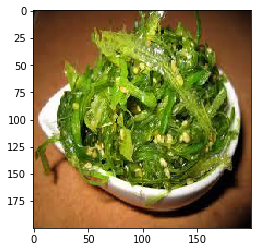

In [133]:
# predict 1 image
source = "valid"
random_folder = np.random.choice(os.listdir(os.path.join("images", source)))
random_image = np.random.choice(os.listdir(os.path.join("images", source, random_folder)))
img = image.load_img(os.path.join( "images", source, random_folder, random_image), target_size = (shape[0], shape[1]))
plt.imshow(img)
img = image.img_to_array(img) / 255
img = np.expand_dims(img, axis = 0)

print("Actual:", random_image)
print("Predicted:", labels[transfer.predict(img).argmax(axis=-1)[0]])